$
\begin{align}
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)G_t] \text{REINFORCE}\\
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)V_w(s)] \text{V actor-critic}\\
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)Q_w(s,a)] \text{Q actor-critic}\\
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)A_w(s,a)] \text{Advantage actor-critic}\\
\end{align}
$

## Q actor critic

In [1]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
from tools import discount_cumsum

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
import tensorflow.keras.backend as K

In [5]:
class DeepAgent:                                                                                                                                                                                                
    def __init__(self, env, is_deterministic = False, gamma = .99, epsilon = .01):                                                                                                                          
        self.env = env                                                                                                                                                                                      
        self.is_deterministic = is_deterministic                                                                                                                                                            
        self.gamma = gamma                                                                                                                                                                                  
        self.epsilon = epsilon                                                                                                                                                                              
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
    def act(self, state):                                                                                                                                                                                   
        if self.is_deterministic:                                                                                                                                                                           
            action = np.argmax(self.policy[state])                                                                                                                                                          
        else:                                                                                                                                                                                               
            action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])                                                                                                              
            return action                                                                                                                                                                                       
        def train(current_state, action, reward, done):                                                                                                                                                         
            pass

In [6]:
import tensorflow.keras.backend as K

def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = K.sum(one_hot_action * K.log(action_probs) + (1 - one_hot_action) * K.log(1 - action_probs), axis=1)
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [55]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class QActorCriticAgent(DeepAgent):
    def __init__(self, env, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .01, alpha = .01, memory_size = 3):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model_actor()
        
        self.model.summary()
        
        self.model_critic = self._build_model_critic()
        
        self.model_critic.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        self.turn = 0
        

    def _build_model_actor(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
        x = Dense(8, activation='relu')(input_state)
        x = Dense(4, activation='relu')(x)
        x = Dense(self.action_dim, activation='softmax')(x)
        model = Model(inputs=input_state, outputs=x)
        return model
    
    def _build_model_critic(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        x = Dense(4, activation='linear')(input_state)
        x = Dense(1, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2))
        return model

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        if done is False:
            self.episode.append(np.array([current_state, action, reward]))
        else:
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            X = np.vstack(episode[:,0])
            Y = np.zeros((len(episode), self.action_dim))
            for i in range(len(episode)):
                Y[i, episode[i,1]] = 1
            if len(self.episodes) == self.memory_size:
                episodes = np.asarray(self.episodes)
                self.episodes = []
                Xs = np.vstack(episodes[:,0])
                Ys = np.vstack(episodes[:,1])
                discounted_returns = np.hstack(episodes[:,2])
                baselines = self.model_critic.predict(Xs)
                print(baselines.max())
                loss = policy_gradient_loss(baselines)
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
                self.model.train_on_batch(Xs,Ys)
                self.model_critic.train_on_batch(Xs,discounted_returns.astype(np.dtype('float32')))
            else:
                self.episodes.append((X,Y,discounted_return))

    def save_model(self, path):
        self.model.save(path)

In [56]:
def run_experiment_episode_train(env, agent, nb_episode):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            agent.train(current_state, action, reward, state, done)
            rews.append(reward)
        rewards[i] = sum(rews)
        print('episode: {} - cum reward {}'.format(i, rewards[i]))
    return rewards

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_93 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_94 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_95 (Dense)             (None, 2)                 10        
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
____________________________________________

episode: 201 - cum reward 24.0
episode: 202 - cum reward 16.0
3.8061812
episode: 203 - cum reward 14.0
episode: 204 - cum reward 13.0
episode: 205 - cum reward 9.0
episode: 206 - cum reward 30.0
5.578916
episode: 207 - cum reward 26.0
episode: 208 - cum reward 25.0
episode: 209 - cum reward 35.0
episode: 210 - cum reward 16.0
6.908552
episode: 211 - cum reward 31.0
episode: 212 - cum reward 15.0
episode: 213 - cum reward 13.0
episode: 214 - cum reward 20.0
5.6664243
episode: 215 - cum reward 13.0
episode: 216 - cum reward 41.0
episode: 217 - cum reward 15.0
episode: 218 - cum reward 13.0
5.7489457
episode: 219 - cum reward 9.0
episode: 220 - cum reward 25.0
episode: 221 - cum reward 19.0
episode: 222 - cum reward 12.0
5.725097
episode: 223 - cum reward 79.0
episode: 224 - cum reward 28.0
episode: 225 - cum reward 22.0
episode: 226 - cum reward 10.0
7.7267914
episode: 227 - cum reward 13.0
episode: 228 - cum reward 39.0
episode: 229 - cum reward 23.0
episode: 230 - cum reward 35.0
6.062

episode: 447 - cum reward 16.0
episode: 448 - cum reward 15.0
episode: 449 - cum reward 19.0
episode: 450 - cum reward 13.0
11.394376
episode: 451 - cum reward 32.0
episode: 452 - cum reward 24.0
episode: 453 - cum reward 20.0
episode: 454 - cum reward 19.0
12.406743
episode: 455 - cum reward 36.0
episode: 456 - cum reward 23.0
episode: 457 - cum reward 13.0
episode: 458 - cum reward 21.0
12.0948305
episode: 459 - cum reward 29.0
episode: 460 - cum reward 14.0
episode: 461 - cum reward 32.0
episode: 462 - cum reward 14.0
10.6876
episode: 463 - cum reward 14.0
episode: 464 - cum reward 29.0
episode: 465 - cum reward 26.0
episode: 466 - cum reward 12.0
12.262808
episode: 467 - cum reward 14.0
episode: 468 - cum reward 28.0
episode: 469 - cum reward 40.0
episode: 470 - cum reward 33.0
12.830342
episode: 471 - cum reward 19.0
episode: 472 - cum reward 22.0
episode: 473 - cum reward 27.0
episode: 474 - cum reward 15.0
12.78282
episode: 475 - cum reward 10.0
episode: 476 - cum reward 22.0
ep

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

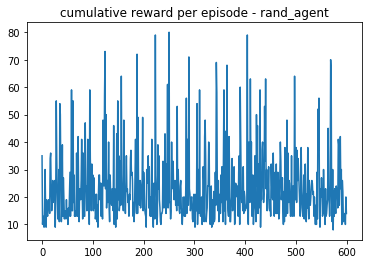

In [57]:
env = gym.make('CartPole-v0')
#env = gym.make('LunarLander-v2')
q_agent = QActorCriticAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 600)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [62]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class QActorCriticAgent(DeepAgent):
    def __init__(self, env, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .01, alpha = .01, memory_size = 3):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model_actor()
        
        self.model.summary()
        
        self.model_critic = self._build_model_critic()
        
        self.model_critic.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        

    def _build_model_actor(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
        x = Dense(8, activation='relu')(input_state)
        x = Dense(4, activation='relu')(x)
        x = Dense(self.action_dim, activation='softmax')(x)
        model = Model(inputs=input_state, outputs=x)
        return model
    
    def _build_model_critic(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        x = Dense(8, activation='relu')(input_state)
        x = Dense(4, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2))
        return model

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        if done is False:
            self.episode.append(np.array([current_state, action, reward, reward + self.gamma * self.model_critic.predict(np.asarray(next_state).reshape(1,-1))]))
        else:
            self.episode.append(np.array([current_state, action, reward, reward]))
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            X = np.vstack(episode[:,0])
            Y_value = np.vstack(episode[:,3])
            Y = np.zeros((len(episode), self.action_dim))
            for i in range(len(episode)):
                Y[i, episode[i,1]] = 1
            if len(self.episodes) == self.memory_size:
                episodes = np.asarray(self.episodes)
                self.episodes = []
                Xs = np.vstack(episodes[:,0])
                Ys = np.vstack(episodes[:,1])
                Y_values = np.vstack(episodes[:,3])
                discounted_returns = np.hstack(episodes[:,2])
                baselines = self.model_critic.predict(Xs)
                loss = policy_gradient_loss(baselines)
                print(baselines.max(), baselines.min())
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
                self.model.train_on_batch(Xs,Ys)
                self.model_critic.train_on_batch(Xs, Y_values)#discounted_returns.astype(np.dtype('float32')))
            else:
                self.episodes.append((X,Y,discounted_return, Y_value))

    def save_model(self, path):
        self.model.save(path)

In [63]:
env = gym.make('CartPole-v0')
q_agent = QActorCriticAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 400)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_110 (Dense)            (None, 8)                 40        
_________________________________________________________________
dense_111 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_112 (Dense)            (None, 2)                 10        
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
____________________________________________

episode: 182 - cum reward 18.0
4.300969 1.4642961
episode: 183 - cum reward 23.0
episode: 184 - cum reward 19.0
episode: 185 - cum reward 39.0
episode: 186 - cum reward 26.0
6.9247036 1.4608411
episode: 187 - cum reward 50.0
episode: 188 - cum reward 16.0
episode: 189 - cum reward 21.0
episode: 190 - cum reward 17.0
6.230141 1.6099274
episode: 191 - cum reward 14.0
episode: 192 - cum reward 12.0
episode: 193 - cum reward 13.0
episode: 194 - cum reward 10.0
5.902809 1.6815988
episode: 195 - cum reward 21.0
episode: 196 - cum reward 8.0
episode: 197 - cum reward 20.0
episode: 198 - cum reward 22.0
7.2704525 1.7319174
episode: 199 - cum reward 26.0
episode: 200 - cum reward 31.0
episode: 201 - cum reward 18.0
episode: 202 - cum reward 14.0
5.381885 1.7804586
episode: 203 - cum reward 14.0
episode: 204 - cum reward 13.0
episode: 205 - cum reward 12.0
episode: 206 - cum reward 31.0
8.533211 1.8830397
episode: 207 - cum reward 15.0
episode: 208 - cum reward 28.0
episode: 209 - cum reward 10.

KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
import gym
import time
import spinup.algos.vpg.core as core
from spinup.utils.logx import EpochLogger
from spinup.utils.mpi_tf import MpiAdamOptimizer, sync_all_params
from spinup.utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs


class VPGBuffer:
    """
    A buffer for storing trajectories experienced by a VPG agent interacting
    with the environment, and using Generalized Advantage Estimation (GAE-Lambda)
    for calculating the advantages of state-action pairs.
    """

    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(core.combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        """
        Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size     # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        """
        Call this at the end of a trajectory, or when one gets cut off
        by an epoch ending. This looks back in the buffer to where the
        trajectory started, and uses rewards and value estimates from
        the whole trajectory to compute advantage estimates with GAE-Lambda,
        as well as compute the rewards-to-go for each state, to use as
        the targets for the value function.
        The "last_val" argument should be 0 if the trajectory ended
        because the agent reached a terminal state (died), and otherwise
        should be V(s_T), the value function estimated for the last state.
        This allows us to bootstrap the reward-to-go calculation to account
        for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
        """

        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        
        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = core.discount_cumsum(deltas, self.gamma * self.lam)
        
        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf[path_slice] = core.discount_cumsum(rews, self.gamma)[:-1]
        
        self.path_start_idx = self.ptr

    def get(self):
        """
        Call this at the end of an epoch to get all of the data from
        the buffer, with advantages appropriately normalized (shifted to have
        mean zero and std one). Also, resets some pointers in the buffer.
        """
        assert self.ptr == self.max_size    # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = mpi_statistics_scalar(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        return [self.obs_buf, self.act_buf, self.adv_buf, 
                self.ret_buf, self.logp_buf]


"""
Vanilla Policy Gradient
(with GAE-Lambda for advantage estimation)
"""
def vpg(env_fn, actor_critic=core.mlp_actor_critic, ac_kwargs=dict(), seed=0, 
        steps_per_epoch=4000, epochs=50, gamma=0.99, pi_lr=3e-4,
        vf_lr=1e-3, train_v_iters=80, lam=0.97, max_ep_len=1000,
        logger_kwargs=dict(), save_freq=10):
    """
    Args:
        env_fn : A function which creates a copy of the environment.
            The environment must satisfy the OpenAI Gym API.
        actor_critic: A function which takes in placeholder symbols 
            for state, ``x_ph``, and action, ``a_ph``, and returns the main 
            outputs from the agent's Tensorflow computation graph:
            ===========  ================  ======================================
            Symbol       Shape             Description
            ===========  ================  ======================================
            ``pi``       (batch, act_dim)  | Samples actions from policy given 
                                           | states.
            ``logp``     (batch,)          | Gives log probability, according to
                                           | the policy, of taking actions ``a_ph``
                                           | in states ``x_ph``.
            ``logp_pi``  (batch,)          | Gives log probability, according to
                                           | the policy, of the action sampled by
                                           | ``pi``.
            ``v``        (batch,)          | Gives the value estimate for states
                                           | in ``x_ph``. (Critical: make sure 
                                           | to flatten this!)
            ===========  ================  ======================================
        ac_kwargs (dict): Any kwargs appropriate for the actor_critic 
            function you provided to VPG.
        seed (int): Seed for random number generators.
        steps_per_epoch (int): Number of steps of interaction (state-action pairs) 
            for the agent and the environment in each epoch.
        epochs (int): Number of epochs of interaction (equivalent to
            number of policy updates) to perform.
        gamma (float): Discount factor. (Always between 0 and 1.)
        pi_lr (float): Learning rate for policy optimizer.
        vf_lr (float): Learning rate for value function optimizer.
        train_v_iters (int): Number of gradient descent steps to take on 
            value function per epoch.
        lam (float): Lambda for GAE-Lambda. (Always between 0 and 1,
            close to 1.)
        max_ep_len (int): Maximum length of trajectory / episode / rollout.
        logger_kwargs (dict): Keyword args for EpochLogger.
        save_freq (int): How often (in terms of gap between epochs) to save
            the current policy and value function.
    """

    logger = EpochLogger(**logger_kwargs)
    logger.save_config(locals())

    seed += 10000 * proc_id()
    tf.set_random_seed(seed)
    np.random.seed(seed)

    env = env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape
    
    # Share information about action space with policy architecture
    ac_kwargs['action_space'] = env.action_space

    # Inputs to computation graph
    x_ph, a_ph = core.placeholders_from_spaces(env.observation_space, env.action_space)
    adv_ph, ret_ph, logp_old_ph = core.placeholders(None, None, None)

    # Main outputs from computation graph
    pi, logp, logp_pi, v = actor_critic(x_ph, a_ph, **ac_kwargs)

    # Need all placeholders in *this* order later (to zip with data from buffer)
    all_phs = [x_ph, a_ph, adv_ph, ret_ph, logp_old_ph]

    # Every step, get: action, value, and logprob
    get_action_ops = [pi, v, logp_pi]

    # Experience buffer
    local_steps_per_epoch = int(steps_per_epoch / num_procs())
    buf = VPGBuffer(obs_dim, act_dim, local_steps_per_epoch, gamma, lam)

    # Count variables
    var_counts = tuple(core.count_vars(scope) for scope in ['pi', 'v'])
    logger.log('\nNumber of parameters: \t pi: %d, \t v: %d\n'%var_counts)

    # VPG objectives
    pi_loss = -tf.reduce_mean(logp * adv_ph)
    v_loss = tf.reduce_mean((ret_ph - v)**2)

    # Info (useful to watch during learning)
    approx_kl = tf.reduce_mean(logp_old_ph - logp)      # a sample estimate for KL-divergence, easy to compute
    approx_ent = tf.reduce_mean(-logp)                  # a sample estimate for entropy, also easy to compute

    # Optimizers
    train_pi = MpiAdamOptimizer(learning_rate=pi_lr).minimize(pi_loss)
    train_v = MpiAdamOptimizer(learning_rate=vf_lr).minimize(v_loss)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # Sync params across processes
    sess.run(sync_all_params())

    # Setup model saving
    logger.setup_tf_saver(sess, inputs={'x': x_ph}, outputs={'pi': pi, 'v': v})

    def update():
        inputs = {k:v for k,v in zip(all_phs, buf.get())}
        pi_l_old, v_l_old, ent = sess.run([pi_loss, v_loss, approx_ent], feed_dict=inputs)

        # Policy gradient step
        sess.run(train_pi, feed_dict=inputs)

        # Value function learning
        for _ in range(train_v_iters):
            sess.run(train_v, feed_dict=inputs)

        # Log changes from update
        pi_l_new, v_l_new, kl = sess.run([pi_loss, v_loss, approx_kl], feed_dict=inputs)
        logger.store(LossPi=pi_l_old, LossV=v_l_old, 
                     KL=kl, Entropy=ent, 
                     DeltaLossPi=(pi_l_new - pi_l_old),
                     DeltaLossV=(v_l_new - v_l_old))

    start_time = time.time()
    o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0

    # Main loop: collect experience in env and update/log each epoch
    for epoch in range(epochs):
        for t in range(local_steps_per_epoch):
            a, v_t, logp_t = sess.run(get_action_ops, feed_dict={x_ph: o.reshape(1,-1)})

            # save and log
            buf.store(o, a, r, v_t, logp_t)
            logger.store(VVals=v_t)

            o, r, d, _ = env.step(a[0])
            ep_ret += r
            ep_len += 1

            terminal = d or (ep_len == max_ep_len)
            if terminal or (t==local_steps_per_epoch-1):
                if not(terminal):
                    print('Warning: trajectory cut off by epoch at %d steps.'%ep_len)
                # if trajectory didn't reach terminal state, bootstrap value target
                last_val = r if d else sess.run(v, feed_dict={x_ph: o.reshape(1,-1)})
                buf.finish_path(last_val)
                if terminal:
                    # only save EpRet / EpLen if trajectory finished
                    logger.store(EpRet=ep_ret, EpLen=ep_len)
                o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0

        # Save model
        if (epoch % save_freq == 0) or (epoch == epochs-1):
            logger.save_state({'env': env}, None)

        # Perform VPG update!
        update()

        # Log info about epoch
        logger.log_tabular('Epoch', epoch)
        logger.log_tabular('EpRet', with_min_and_max=True)
        logger.log_tabular('EpLen', average_only=True)
        logger.log_tabular('VVals', with_min_and_max=True)
        logger.log_tabular('TotalEnvInteracts', (epoch+1)*steps_per_epoch)
        logger.log_tabular('LossPi', average_only=True)
        logger.log_tabular('LossV', average_only=True)
        logger.log_tabular('DeltaLossPi', average_only=True)
        logger.log_tabular('DeltaLossV', average_only=True)
        logger.log_tabular('Entropy', average_only=True)
        logger.log_tabular('KL', average_only=True)
        logger.log_tabular('Time', time.time()-start_time)
        logger.dump_tabular()

if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--env', type=str, default='HalfCheetah-v2')
    parser.add_argument('--hid', type=int, default=64)
    parser.add_argument('--l', type=int, default=2)
    parser.add_argument('--gamma', type=float, default=0.99)
    parser.add_argument('--seed', '-s', type=int, default=0)
    parser.add_argument('--cpu', type=int, default=4)
    parser.add_argument('--steps', type=int, default=4000)
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--exp_name', type=str, default='vpg')
    args = parser.parse_args()

    mpi_fork(args.cpu)  # run parallel code with mpi

    from spinup.utils.run_utils import setup_logger_kwargs
    logger_kwargs = setup_logger_kwargs(args.exp_name, args.seed)

    vpg(lambda : gym.make(args.env), actor_critic=core.mlp_actor_critic,
        ac_kwargs=dict(hidden_sizes=[args.hid]*args.l), gamma=args.gamma, 
        seed=args.seed, steps_per_epoch=args.steps, epochs=args.epochs,
        logger_kwargs=logger_kwargs)